In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as pl
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [2]:
from PIL import Image
from pathlib import Path
from bidict import bidict
from lime import lime_image
from typing import Union
from dataclasses import dataclass
from torchvision import transforms
from skimage.segmentation import mark_boundaries
from lime.wrappers.scikit_image import SegmentationAlgorithm

/home/hope/Repositories/flower-eng-thesis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from Models.CNN_model import CNN
from Models.VGG19_model import VGG19

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
%%capture
cnn = CNN()
cnn.load_state_dict(torch.load("../assets/cnn_model.pth", map_location=device))
cnn.eval()

original_vgg19_model = models.vgg19(weights="VGG19_Weights.DEFAULT")
vgg = VGG19(original_vgg19_model)
vgg.load_state_dict(torch.load("../assets/vgg19_transfer.pth", map_location=device))
vgg.eval()

In [6]:
image_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.Normalize(
            mean=[0.1855, 0.1855, 0.1855], std=[0.2003, 0.2003, 0.2004]
        ),
    ]
)

preprocess_transform = transforms.ToTensor()

In [7]:
classes = bidict({0: "glioma", 1: "meningioma", 2: "notumor", 3: "pituitary"})

In [8]:
def choose_random_image() -> tuple[Image, int]:
    image_path = list(Path("../assets/Dataset/Testing/").glob("*/*.jpg"))
    image_path = random.choice(image_path)
    image_class = image_path.parent.stem

    image = Image.open(image_path)
    image = image.convert("RGB")
    image = image.resize((224, 224))

    pl.rcParams.update({"font.size": 13})
    pl.figure(figsize=(6, 6))
    pl.imshow(image)
    pl.title(f"Orginal class = {image_class}")
    pl.axis("off")
    pl.show()

    return image, image_class

In [9]:
def get_model_prediction(model, image) -> int:
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.1855, 0.1855, 0.1855], std=[0.2003, 0.2003, 0.2004]
            ),
        ]
    )

    input_tensor = transform(image)
    input_batch = input_tensor.unsqueeze(0)

    with torch.no_grad():
        output = model(input_batch)

    return torch.argmax(output[0]).item()

In [10]:
@dataclass
class Params:
    image_path: str
    image_class: int
    num_samples: int
    num_features: int
    positive_only: bool
    kernel_size: int
    ratio: float
    max_dist: int
    order: bool

Quickshift default settings
- kernel_size = 4
- max_dist = 200
- ratio = 0.2

In [75]:
def explain_with_lime(
    model: nn.Module, params: Params
) -> Union[np.ndarray, list[np.ndarray]]:
    image = Image.open(params.image_path)
    image = image.convert("RGB")
    image = image.resize((224, 224))
    print(f"Model prediction = {classes[get_model_prediction(model, image)]}")
    image = np.array(image)

    def batch_predict(images: np.ndarray) -> np.ndarray:
        model.eval()
        batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

        batch = batch.to(device)
        logits = model(batch)
        probs = F.softmax(logits, dim=1)

        return probs.detach().cpu().numpy()

    segmenter = SegmentationAlgorithm(
        "quickshift",
        kernel_size=params.kernel_size,
        max_dist=params.max_dist,
        ratio=params.ratio,
    )

    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image=image,
        classifier_fn=batch_predict,
        segmentation_fn=segmenter,
        num_samples=params.num_samples,
    )

    print(f"Top label = {classes[explanation.top_labels[0]]}")

    if not params.order:
        temp, mask = explanation.get_image_and_mask(
            label=params.image_class,
            positive_only=params.positive_only,
            num_features=params.num_features,
        )
        return mark_boundaries(temp / 255.0, mask)
    else:
        marked_images: list[np.ndarray] = []
        prev_image: np.ndarray = np.zeros((224, 224, 3), dtype=np.int8)
        prev_mask: np.ndarray = np.zeros((224, 224), dtype=np.int8)
        for i in range(params.num_features):
            temp, mask = explanation.get_image_and_mask(
                label=params.image_class,
                positive_only=params.positive_only,
                num_features=i,
            )

            if np.count_nonzero(prev_image) == 0:
                marked_images.append(mark_boundaries(temp / 255.0, mask))
            else:
                marked_images.append(mark_boundaries(image + temp - prev_image, mask - prev_mask))

            prev_image = temp
            prev_mask = mask
        return marked_images

Model prediction = pituitary


100%|██████████| 200/200 [00:02<00:00, 73.62it/s] 

Top label = pituitary


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

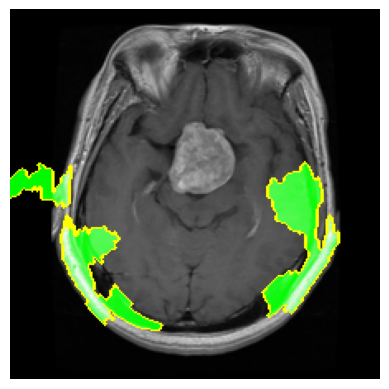

In [76]:
params = Params(
    image_path="../assets/test_pituitary.jpg",
    image_class=classes.inverse["pituitary"],
    num_samples=200,
    num_features=5,
    positive_only=False,
    kernel_size=2,
    max_dist=200,
    ratio=0.2,
    order=False,
)

image = explain_with_lime(cnn, params)

pl.imshow(image)
pl.axis("off")

In [77]:
params = Params(
    image_path="../assets/test_pituitary.jpg",
    image_class=classes.inverse["pituitary"],
    num_samples=200,
    num_features=5,
    positive_only=False,
    kernel_size=2,
    max_dist=200,
    ratio=0.2,
    order=True,
)

images = explain_with_lime(cnn, params)

Model prediction = pituitary


100%|██████████| 200/200 [00:01<00:00, 111.41it/s]


Top label = pituitary


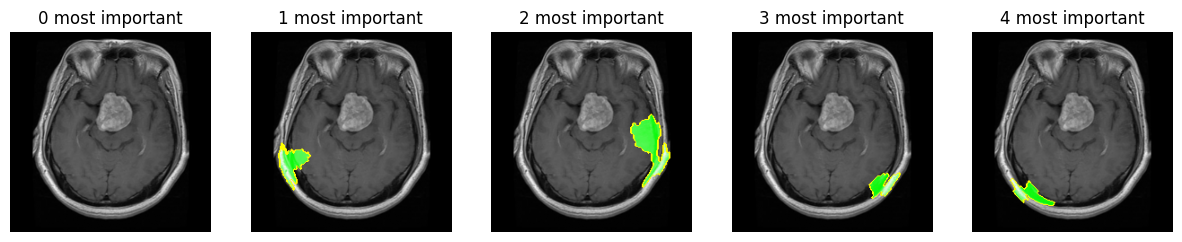

In [81]:
fig, axes = pl.subplots(1, 5, figsize=(15, 3))

for i, (ax, img) in enumerate(zip(axes, images)):
    ax.imshow(img)
    ax.set_title(f'{i} most important')
    ax.axis('off')